## Super resolution

In [35]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from  modified_model_fx import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
torch.cuda.set_device(2)

In [4]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96pets'
path_mr = path/'small-256pets'

In [5]:
il = ImageList.from_folder(path_hr)

In [6]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [7]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

resizing to 96 into /home/marvande/image_super_resolution/source/image_super_res/data/oxford-iiit-pet/small-96pets


resizing to 256 into /home/marvande/image_super_resolution/source/image_super_res/data/oxford-iiit-pet/small-256pets


In [8]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)
src

ItemLists;

Train: ImageImageList (1486 items)
Image (3, 96, 144),Image (3, 96, 101),Image (3, 105, 96),Image (3, 96, 143),Image (3, 96, 136)
Path: /home/marvande/image_super_resolution/source/image_super_res/data/oxford-iiit-pet/small-96pets;

Valid: ImageImageList (165 items)
Image (3, 96, 147),Image (3, 96, 144),Image (3, 96, 144),Image (3, 96, 120),Image (3, 144, 96)
Path: /home/marvande/image_super_resolution/source/image_super_res/data/oxford-iiit-pet/small-96pets;

Test: None

In [9]:
def get_data(bs,size):
    #data = (src.label_from_func(lambda x: path_hr/x.relative_to(path_lr)).transform(get_transforms(max_zoom=2.), size=size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data = (src.label_from_func(lambda x: path_hr/x.relative_to(path_lr))
            .transform(tfms, size=size, tfm_y=True)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [10]:
# Remove affine transformations:
tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [11]:
data = get_data(bs,size)

In [12]:
data

ImageDataBunch;

Train: LabelList (1486 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/marvande/image_super_resolution/source/image_super_res/data/oxford-iiit-pet/small-96pets;

Valid: LabelList (165 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/marvande/image_super_resolution/source/image_super_res/data/oxford-iiit-pet/small-96pets;

Test: None

In [33]:
# lr 
x = data.one_batch(ds_type=DatasetType.Valid)[0][0]
# hr
y = data.one_batch(ds_type=DatasetType.Valid)[1][0]
x.shape, y.shape

(torch.Size([3, 128, 128]), torch.Size([3, 128, 128]))

In [37]:
MSE = mse_mult_chann(x.numpy(), y.numpy())
NMSE = measure.compare_nrmse(x.numpy(), y.numpy())
SSIM = ssim_mult_chann(x.numpy(), y.numpy())
print('MSE: {}, NMSE: {}, SSIM: {}'.format(MSE, NMSE, SSIM))

MSE: 0.0009475218459973579, NMSE: 0.06641065899378322, SSIM: 0.9325379113902392


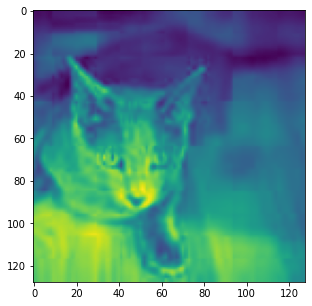

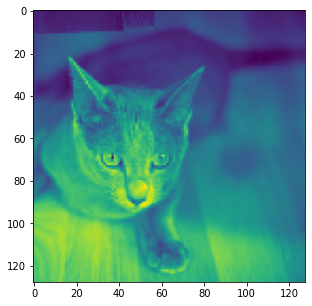

In [36]:
plot_single_image(x, '', (5,5))
plot_single_image(y, '', (5,5))

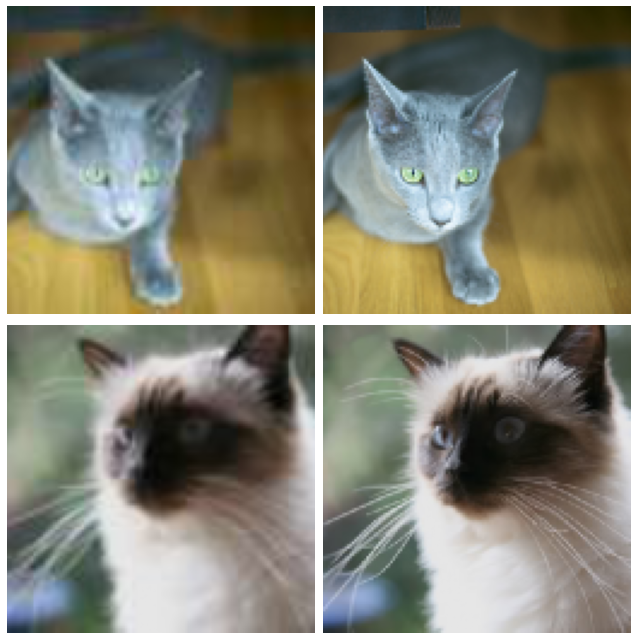

In [13]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [14]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [15]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [16]:
gram_matrix(t)

tensor([[[0.0817, 0.0790, 0.0596],
         [0.0790, 0.0784, 0.0624],
         [0.0596, 0.0624, 0.0558]],

        [[0.0817, 0.0790, 0.0596],
         [0.0790, 0.0784, 0.0624],
         [0.0596, 0.0624, 0.0558]]])

In [17]:
base_loss = F.l1_loss

In [21]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

NameError: name 'vgg16_bn' is not defined

In [ ]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

In [19]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [20]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

NameError: name 'vgg_m' is not defined

## Train

In [21]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


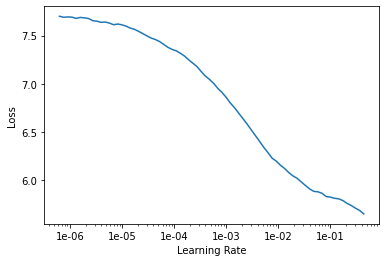

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
lr = 1e-3

In [24]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.612309,3.581181,0.134023,0.225965,0.308152,0.217189,0.516013,1.157980,1.021859,01:49
1,3.467462,3.423505,0.135453,0.221689,0.299137,0.206125,0.482926,1.109205,0.968970,01:48
2,3.374510,3.383112,0.138728,0.221340,0.294556,0.201332,0.478136,1.100425,0.948596,01:48
3,3.310070,3.339844,0.151494,0.220191,0.291181,0.198982,0.463251,1.078859,0.935885,01:48
4,3.243057,3.227917,0.138354,0.216024,0.283536,0.192087,0.447079,1.047993,0.902845,01:48
5,3.205502,3.206636,0.133929,0.214884,0.281608,0.191280,0.441709,1.036368,0.906859,01:48
6,3.168676,3.160567,0.134899,0.212415,0.278150,0.188210,0.433432,1.024218,0.889244,01:48
7,3.145133,3.145950,0.132446,0.212758,0.277079,0.186729,0.434370,1.021868,0.880700,01:48
8,3.101558,3.127459,0.130965,0.211501,0.275083,0.186850,0.422753,1.011986,0.888320,01:48
9,3.009030,3.004502,0.126437,0.207962,0.267712,0.178195,0.403662,0.977473,0.843062,01:48


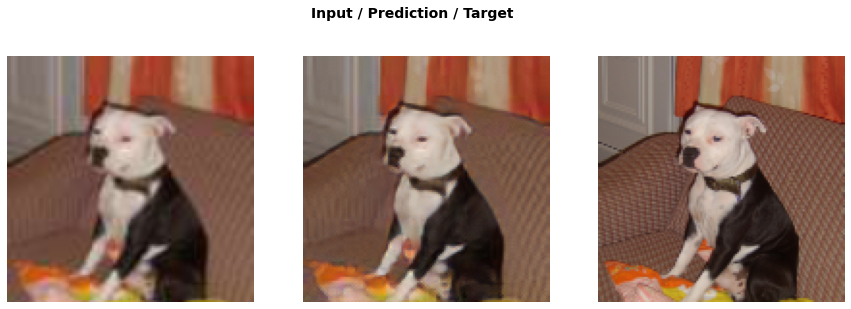

In [25]:
do_fit('1a', slice(lr*10))

In [26]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.979798,2.996351,0.126565,0.208227,0.267743,0.177758,0.400260,0.975599,0.840199,01:53
1,2.964440,2.990466,0.126366,0.207882,0.267288,0.177398,0.400005,0.973785,0.837741,01:53
2,2.962124,2.983788,0.126068,0.207776,0.266742,0.176953,0.398683,0.971958,0.835609,01:53
3,2.949052,2.981707,0.125925,0.207148,0.266123,0.176861,0.399956,0.970356,0.835338,01:53
4,2.954251,2.972563,0.126103,0.207008,0.265595,0.176284,0.397189,0.967882,0.832502,01:53
5,2.932787,2.969423,0.126211,0.206680,0.265496,0.176019,0.396541,0.967977,0.830499,01:53
6,2.937184,2.964905,0.126141,0.206797,0.265089,0.175824,0.395182,0.964689,0.831182,01:53
7,2.936887,2.961403,0.126614,0.206739,0.264731,0.175828,0.393062,0.963808,0.830621,01:53
8,2.932587,2.967173,0.126248,0.206305,0.264571,0.175981,0.394415,0.966648,0.833005,01:53
9,2.882314,2.941743,0.125934,0.205725,0.263439,0.174335,0.390227,0.959464,0.822619,01:53


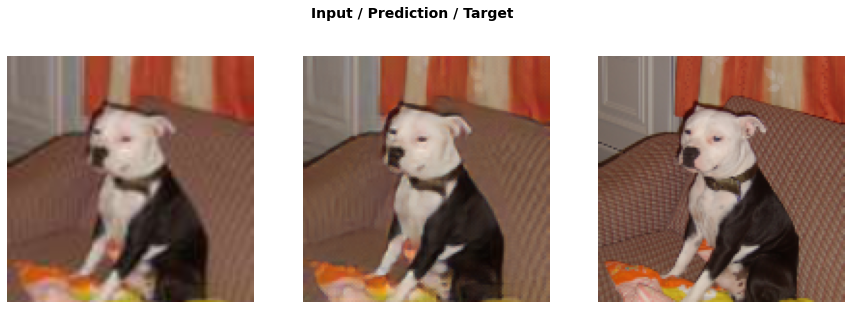

In [27]:
do_fit('1b', slice(1e-5,lr))

In [18]:
data = get_data(12,size*2)


In [19]:
data

ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/marvande/.fastai/data/oxford-iiit-pet/small-96pets;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/marvande/.fastai/data/oxford-iiit-pet/small-96pets;

Test: None

In [29]:
learn.data = data
learn.freeze()
gc.collect()

20429

In [30]:
learn.load('1b');

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.269908,2.270680,0.156984,0.261093,0.303485,0.161121,0.406629,0.595739,0.385627,07:21
1,2.203844,2.202974,0.157641,0.259670,0.298712,0.157440,0.378465,0.579238,0.371808,07:16
2,2.155008,2.156607,0.157773,0.256986,0.293427,0.153479,0.364165,0.568403,0.362373,07:16
3,2.134934,2.118063,0.158397,0.255596,0.289479,0.151012,0.348993,0.558812,0.355774,07:16
4,2.089804,2.095811,0.157569,0.253123,0.285725,0.147597,0.348913,0.553428,0.349456,07:16
5,2.064927,2.073547,0.158947,0.253029,0.284016,0.146869,0.336548,0.547372,0.346766,07:16
6,2.060143,2.061472,0.158338,0.252106,0.282542,0.145904,0.334879,0.544327,0.343376,07:15
7,2.048799,2.055785,0.160313,0.252140,0.281432,0.145183,0.331779,0.542022,0.342917,07:15
8,2.026536,2.032679,0.156592,0.249730,0.278941,0.143367,0.329690,0.535851,0.338507,07:15
9,1.993765,2.012094,0.156866,0.250281,0.277724,0.142695,0.318530,0.529743,0.336255,07:15


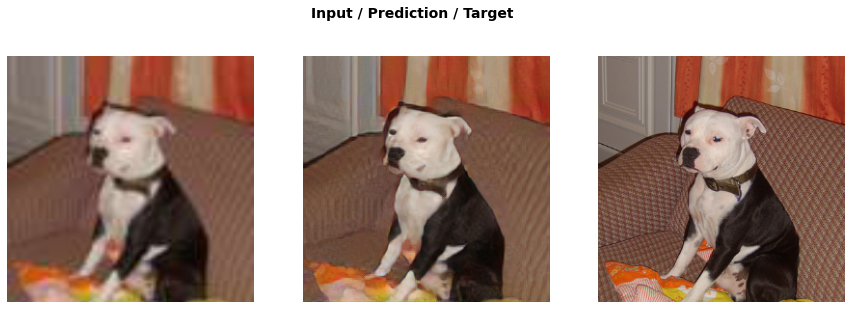

In [31]:
do_fit('2a')

In [32]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.012387,2.010293,0.156903,0.250230,0.277572,0.142388,0.318455,0.529110,0.335635,07:30
1,1.984368,2.007575,0.157187,0.250065,0.277332,0.142063,0.317885,0.528109,0.334933,07:31
2,1.994323,2.004644,0.156023,0.249782,0.276786,0.141780,0.318212,0.527733,0.334327,07:31
3,1.983232,1.999870,0.156451,0.249695,0.276658,0.141506,0.316109,0.525883,0.333568,07:31
4,1.980891,2.000169,0.156546,0.248937,0.276017,0.141131,0.318392,0.526029,0.333117,07:31
5,1.987465,1.997342,0.156212,0.248776,0.275794,0.140968,0.317620,0.524898,0.333075,07:31
6,1.975110,1.995334,0.156472,0.249358,0.275992,0.140999,0.315121,0.524599,0.332793,07:31
7,1.970305,1.994150,0.156737,0.249624,0.276131,0.141142,0.313516,0.524343,0.332656,07:31
8,1.972888,1.994055,0.156855,0.249464,0.276058,0.141098,0.313898,0.524159,0.332524,07:31
9,1.974866,1.994580,0.156656,0.249267,0.275912,0.141085,0.314532,0.524330,0.332798,07:31


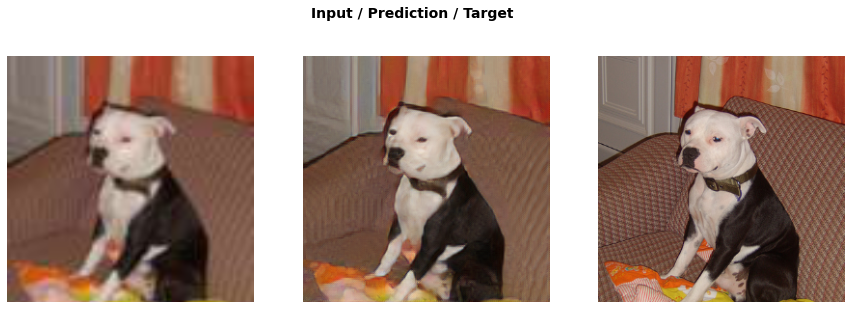

In [33]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [22]:
learn = None
gc.collect();

In [23]:
256/320*1024

819.2

In [24]:
256/320*1600

1280.0

In [25]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(1280, 1600), have 8944MB of GPU RAM free


In [26]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [31]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(tfms, size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3
data_mr

ImageDataBunch;

Train: LabelList (1486 items)
x: ImageImageList
Image (3, 1280, 1600),Image (3, 1280, 1600),Image (3, 1280, 1600),Image (3, 1280, 1600),Image (3, 1280, 1600)
y: ImageList
Image (3, 1280, 1600),Image (3, 1280, 1600),Image (3, 1280, 1600),Image (3, 1280, 1600),Image (3, 1280, 1600)
Path: /home/marvande/image_super_resolution/source/image_super_res/data/oxford-iiit-pet/small-256pets;

Valid: LabelList (165 items)
x: ImageImageList
Image (3, 1280, 1600),Image (3, 1280, 1600),Image (3, 1280, 1600),Image (3, 1280, 1600),Image (3, 1280, 1600)
y: ImageList
Image (3, 1280, 1600),Image (3, 1280, 1600),Image (3, 1280, 1600),Image (3, 1280, 1600),Image (3, 1280, 1600)
Path: /home/marvande/image_super_resolution/source/image_super_res/data/oxford-iiit-pet/small-256pets;

Test: None

In [41]:
learn.load('2b');

In [42]:
learn.data = data_mr

In [28]:
fn = data_mr.valid_ds.x.items[0]
fn

PosixPath('/home/marvande/image_super_resolution/source/image_super_res/data/oxford-iiit-pet/small-256pets/Russian_Blue_75.jpg')

In [29]:
img = open_image(fn); img.shape

torch.Size([3, 256, 392])

In [45]:
p,img_hr,b = learn.predict(img)

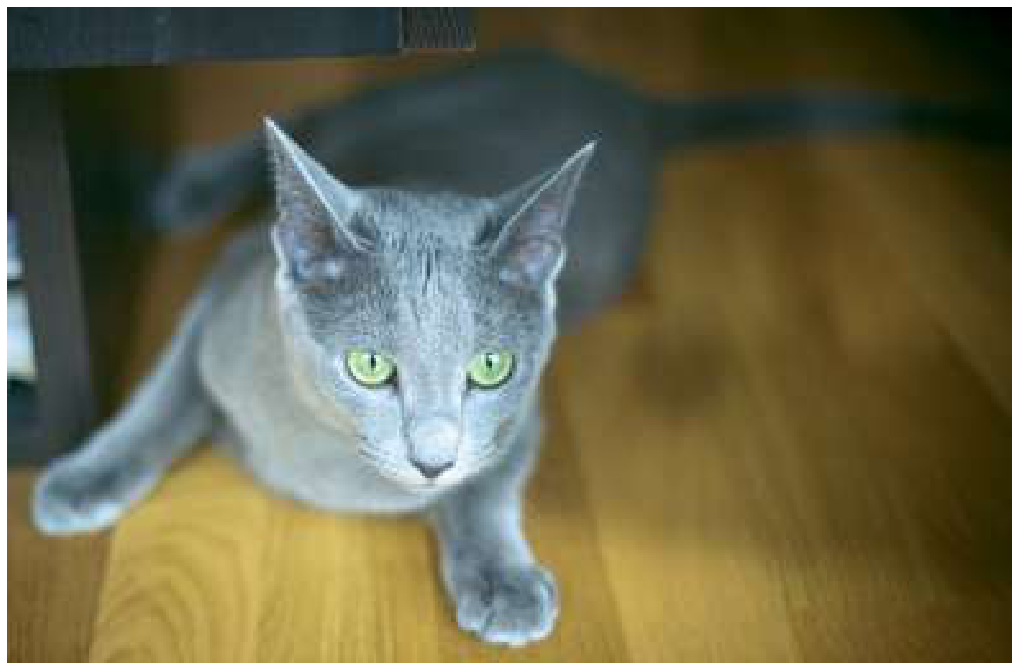

In [30]:
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


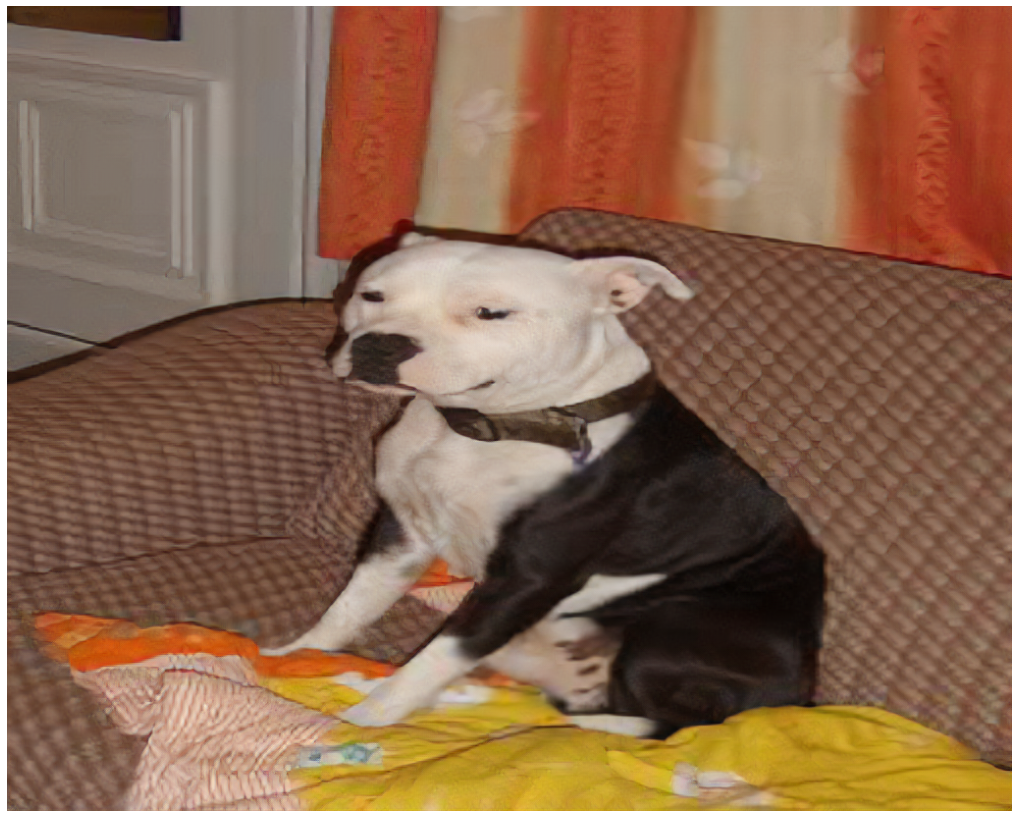

In [49]:
Image(img_hr).show(figsize=(18,15))